# Modeling the NREL bifacial PV Horizontal Single-Axis Tracking System with pySAM

The National Renewable Energy Laboratory, Bifacial Experimental Single-Axis Tracking Field (BEST field) is located at the NREL South Table Mountain Campus, in Golden CO (39.7398341° North, -105.1727827° West).

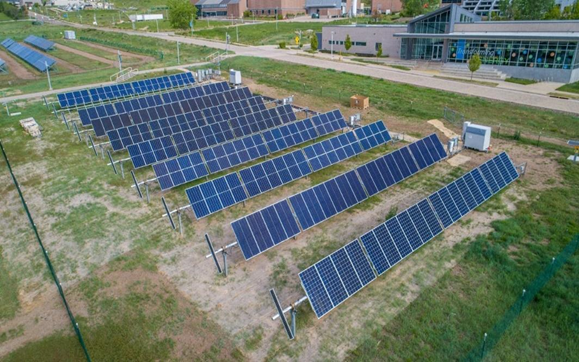

This journal shows how to model the irradiance and performance of the field with pySAM.

<ol>
    <li> <a href='#step1'> Create a default pySAM PV simulation </a></li>
    <li> <a href='#step2'> Set our system values </a></li>
    <li> <a href='#step3'> Assign Solar Resource </a></li>
    <li> <a href='#step4'> Assign the Module </a></li>
        <ul> <li> <a href='#step4a'> Get File through PVLib </a></li>
            <li> <a href='#step4b'> Get File from the SAM repository URL </a></li>
            <li> <a href='#step4c'> From a local file </a></li></ul>
    <li> <a href='#step5'> Assign the Inverter </a></li>
    <li> <a href='#step6'> Assign Calculated Values From the GUI </a></li>
    <li> <a href='#step7'> Execute, Save and Explore Outputs </a></li>
     <li> <a href='#step8'> Extra: Comparison of pySAM vs SAM GUI values </a></li>


The parameters of the BEST field will be inputed throughout the journal to simulate the field that we have. For more details on where the parameters come from, you can look at the [Duramat Datahub: Manual and Field data for the Bifacial Experiment Single-axis Tracked (BEST) field at NREL](https://datahub.duramat.org/dataset/best-field-data)

Please note that this field is 5 different technologies, but for modeling bifacial PV, since SAM uses a view factor model, we are assuming that all rows are the same technology to evaluate the front and rear irradiance. To evalute performance, then we normalize by the system capacity.

In [1]:
Workingfolder = '.'

In [2]:
import PySAM.Pvsamv1 as pv
import PySAM
import xlsxwriter
import json
import pandas as pd
import os
import pprint as pp


In [3]:
PySAM.__version__

'7.1.0'

<a id='step1'></a>

## 1. Create a default pySAM PV simulation 

Doing Commercial type because the size is bigger and it's tracking than a rooftop. We are not really interested in the financial model here though just in the irradiance and power generation so you can choose a different one if you want 

In [4]:
sam1 = pv.default("FlatPlatePVCommercial")

You can explore attributes of the pySAM object with the below cell. This will give variables, methods, etc.

In [5]:
#dir(sam1)

You can also query a single attribute. And export it to see the contents more easily 

In [6]:
sam1.__getattribute__('SolarResource').use_wf_albedo
dic = sam1.export()
dic

{'SolarResource': {'albedo': (0.2,
   0.2,
   0.2,
   0.2,
   0.2,
   0.2,
   0.2,
   0.2,
   0.2,
   0.2,
   0.2,
   0.2),
  'albedo_spatial': ((0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2),
   (0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2),
   (0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2),
   (0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2),
   (0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2),
   (0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2),
   (0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2),
   (0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2),
   (0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2),
   (0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2),
   (0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2),
   (0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2)),
  'irrad_mode': 0.0,
  'sky_model': 2.0,
  'use_spatial_albedos': 0.0,
  'use_wf_albedo': 1.0},
 'Losses': {'acwiring_loss': 1.0,
  'calculate_bifacial_electrical_mismatch': 1.0,
  'calculate_rack_

Or save it as a excell or csv file, if you want to explore the categories and variables

In [7]:
filesave = os.path.join(Workingfolder, 'pySAM_Pvsamv1_default_values.xlsx')

workbook = xlsxwriter.Workbook(filesave)
worksheet = workbook.add_worksheet()
row = 0
col = 0
order=sorted(dic.keys())
for key in order:
    row += 1
    worksheet.write(row, col,     key)
    for item in dic[key]:
        worksheet.write(row, col + 1, item)
        worksheet.write(row, col + 2, str(dic[key][item]))

        row += 1

workbook.close()

<a id='step2'></a>

## 2.  Set our system values

In [8]:
solar_resource_file = os.path.abspath(os.path.join(Workingfolder,'SRRL_WeatherFile_SAM_60_2020.csv'))
albedo = [0.20000000298023224, 0.20000000298023224, 0.20000000298023224, 0.20000000298023224, 0.20000000298023224, 0.20000000298023224, 0.20000000298023224, 0.20000000298023224, 0.20000000298023224, 0.20000000298023224, 0.20000000298023224, 0.20000000298023224]

subarray1_track_mode = 1
subarray1_backtrack = 1
subarray1_rotlim = 50

subarray1_gcr = 0.34903
subarray1_modules_per_string = 20
subarray1_nstrings = 10
subarray1_nmodx = 20
subarray1_nmody = 1
subarray1_shade_mode = 1

inverter_count = 10

subarray1_rear_irradiance_loss = 10
subarray1_soiling = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
use_wf_albedo = 1
# cec_a_ref = 1.885731
# inv_snl_vdco = 310
#  part of Inverter mppt_low_inverter = 100
subarray1_tilt = 0 


In [9]:
newval = { 'SolarResource': {
                            'albedo': albedo,
                            'use_wf_albedo': use_wf_albedo},
           'SystemDesign' : {
                            'inverter_count':inverter_count,
                            'subarray1_backtrack':subarray1_backtrack,
                            'subarray1_gcr':subarray1_gcr,
                            'subarray1_modules_per_string':subarray1_modules_per_string,
                            'subarray1_nstrings':subarray1_nstrings,
                            'subarray1_rotlim':subarray1_rotlim,
                            'subarray1_track_mode':subarray1_track_mode,
                            'subarray1_tilt': subarray1_tilt},
            'Layout':      {
                            'subarray1_nmodx':subarray1_nmodx,
                            'subarray1_nmody':subarray1_nmody},
            'Shading' :    {'subarray1_shade_mode':subarray1_shade_mode},
            'Losses' :     {
                            'subarray1_soiling':subarray1_soiling}
             }



We are going to use the method <b>'assign'</b>, becasue that only replaces the values we are providing. <b>'replace'</b> replaces all the internally generated dictionary entries with only the ones we are providing. 

In [10]:
sam1.assign(newval)

<a id='step3'></a>

## 3. Assign Solar Resource

No solar resource is assigned by default. If this is not assigned the simulation will not run.

In [11]:
sam1.SolarResource.solar_resource_file = solar_resource_file

<a id='step4'></a>

## 4. Assign the PV Module

We first have to get the Module data from the CECe database. Two methods are explored: 

A. Using PVLib

B. getting SAM's CEC library URL and reading the csv.

C. 

<a id='step4a'></a>

#### 4A. Using PVLib

In [12]:
import pvlib
CECMODS = pvlib.pvsystem.retrieve_sam(name='CECMod')

# the CEC modules are a pandas DataFrame oriented as columns, transpose to arrange
# as indices
CECMODS.T.head()

,Technology,Bifacial,STC,PTC,A_c,Length,Width,N_s,I_sc_ref,V_oc_ref,...,a_ref,I_L_ref,I_o_ref,R_s,R_sh_ref,Adjust,gamma_r,BIPV,Version,Date
A10Green_Technology_A10J_S72_175,Mono-c-Si,0,175.0914,151.2,1.3,1.576,0.825,72,5.17,43.99,...,1.981696,5.175703,0.0,0.316688,287.102203,16.057121,-0.5072,N,SAM 2018.11.11 r2,1/3/2019
A10Green_Technology_A10J_S72_180,Mono-c-Si,0,179.928,155.7,1.3,1.576,0.825,72,5.31,44.06,...,1.988414,5.316148,0.0,0.299919,259.047943,16.418983,-0.5072,N,SAM 2018.11.11 r2,1/3/2019
A10Green_Technology_A10J_S72_185,Mono-c-Si,0,184.7016,160.2,1.3,1.576,0.825,72,5.43,44.14,...,1.984817,5.435676,0.0,0.311962,298.424438,15.688233,-0.5072,N,SAM 2018.11.11 r2,1/3/2019
A10Green_Technology_A10J_M60_220,Multi-c-Si,0,219.876,189.1,1.624,1.632,0.995,60,7.95,36.06,...,1.673094,7.959062,0.0,0.140393,123.168404,21.875164,-0.5196,N,SAM 2018.11.11 r2,1/3/2019
A10Green_Technology_A10J_M60_225,Multi-c-Si,0,224.9856,193.5,1.624,1.632,0.995,60,8.04,36.24,...,1.671782,8.047206,0.0,0.14737,164.419479,20.698376,-0.5196,N,SAM 2018.11.11 r2,1/3/2019


The Module we want for this simulation has this name in SAM: <b> "Prism Solar Technologies_ Inc. Bi72-457BSTC" </b>. The name should be written similar with underscores, but is not always teh same in the database. To make it easier, we filter by keywords.

In [13]:
cs_220m_mods = CECMODS.T.index.str.startswith('Prism') & CECMODS.T.index.str.contains('457BSTC')
mymod = CECMODS.T[cs_220m_mods]
mymod.T

,Prism_Solar_Technologies_Bi72_457BSTC
Technology,Multi-c-Si
Bifacial,1
STC,360.214
PTC,327.6
A_c,1.979
Length,2.011
Width,0.984
N_s,72
I_sc_ref,9.8
V_oc_ref,48.2


Asigning variables about the bifaciality aspect of our site. This are saved inside the <b> 'CECPerformanceModelWithModuleDatabase' </b> but are not in the CEC table, they are default/user provided

<a id='step4b'></a>

#### B. Get File from the SAM repository URL

In [14]:
import requests

The URL you see when you navigate to the github looks like:

    >> https://github.com/NREL/SAM/blob/master/deploy/libraries/CEC%20Modules.csv
    
However, to access it you must rename the github.com to raw.githubusercontent.com, and also remove the 'blob' part, so

    >> https://raw.githubusercontent.com/NREL/SAM/master/deploy/libraries/CEC%20Modules.csv'


In [15]:
url = 'https://raw.githubusercontent.com/NREL/SAM/master/deploy/libraries/CEC%20Modules.csv'
df = pd.read_csv(url, index_col=0)
modfilter = df.index.str.startswith('Prism') & df.index.str.contains('457BSTC')
try:
    df[modfilter]
except Exception as e:
    print(e)
    print("Module is no longer found in library. See if the name has changed.")


<div class="alert alert-block alert-warning">
<b>Note:</b> we are atually going to use an older commit by repeating the above procedure but pointing to that blob. This might not be necessary or might change later on
</div>


In [16]:
masterdate = mymod['Date'][0]

/var/folders/yh/xvlf1svn0xq6r2l4hzsggz2xt3qfdr/T/ipykernel_35906/2089502906.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  masterdate = mymod['Date'][0]


In [17]:
# use an older CEC Modules.csv file than master in order to find the right Module
url = 'https://raw.githubusercontent.com/NREL/SAM/7f36ab42df330ebeddfb80dd0c405cc578fcdafc/deploy/libraries/CEC%20Modules.csv'
df = pd.read_csv(url, index_col=0)
modfilter = df.index.str.startswith('Prism') & df.index.str.contains('457BSTC')
mymod = df[modfilter]
mymod
otherbranchdate = mymod['Date'][0]

/var/folders/yh/xvlf1svn0xq6r2l4hzsggz2xt3qfdr/T/ipykernel_35906/3381241117.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  otherbranchdate = mymod['Date'][0]


In [18]:
print("Master database is dated:", masterdate)
print("Older database is dated:", otherbranchdate)

Master database is dated: 1/3/2019
Older database is dated: 11/20/2020


<a id='step4c'></a>

#### C. From a local file

We are commenting this method out because it assumes you have the CEC database saved locally in your computer. 

<div class="alert alert-block alert-warning">
<b>Note:</b> Please note that 'download' from Github web interface messes up the csv properties and this would fail.</div>


In [19]:
#localCECfile= r'C:\Users\sayala\Documents\GitHub\RTCanalysis\BEST_Sam_PVsyst_BR_BVF_Results\pySAM\CEC Modules.csv'

#df = pd.read_csv(localCECfile, index_col=0)
#mymod = df.index.str.startswith('Prism') & df.index.str.contains('457BSTC')
#df[mymod].T


#### Assign the Variables to the SAM object from the CEC data

This are read as strings, so we need to convert them to integers, floats as needed.

In [20]:
cec_a_ref = float(mymod.a_ref[0]) # 1.885731
cec_adjust = float(mymod.Adjust[0]) # 10.400029
cec_alpha_sc = float(mymod.alpha_sc[0]) # 0.004675
cec_area = float(mymod.A_c[0]) # 1.979

cec_beta_oc = float(mymod.beta_oc[0]) # -0.139925
cec_gamma_r = float(mymod.gamma_r[0]) # -0.4028
cec_i_l_ref = float(mymod.I_L_ref[0]) # 9.80468
cec_i_mp_ref = float(mymod.I_mp_ref[0]) # 9.26
cec_i_o_ref = float(mymod.I_o_ref[0]) # 7.72903e-11       # NOT THE SAME, DB says "0.0"
cec_i_sc_ref = float(mymod.I_sc_ref[0]) # 9.8
cec_is_bifacial = int(mymod.Bifacial[0]) # 1
cec_module_length = float(mymod.Length[0]) # 2.011
cec_module_width = float(mymod.Width[0]) # 0.984
module_aspect_ratio = cec_module_length/cec_module_width    # 2.043699187


cec_n_s = float(mymod.N_s[0]) # 72
cec_r_s = float(mymod.R_s[0]) #0.396799
cec_r_sh_ref = float(mymod.R_sh_ref[0]) # 830.975492
cec_t_noct = float(mymod.T_NOCT[0]) # 47.4
cec_v_mp_ref = float(mymod.V_mp_ref[0]) # 38.9
cec_v_oc_ref = float(mymod.V_oc_ref[0]) # 48.2


/var/folders/yh/xvlf1svn0xq6r2l4hzsggz2xt3qfdr/T/ipykernel_35906/3652071070.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cec_a_ref = float(mymod.a_ref[0]) # 1.885731
/var/folders/yh/xvlf1svn0xq6r2l4hzsggz2xt3qfdr/T/ipykernel_35906/3652071070.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cec_adjust = float(mymod.Adjust[0]) # 10.400029
/var/folders/yh/xvlf1svn0xq6r2l4hzsggz2xt3qfdr/T/ipykernel_35906/3652071070.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a 

We also need to assign the values from our bifacial field and assumptions. For this simulation, we are assuming the transmission factor is 0. From our flash test, we also know that the bifaciality factor is 0.694. Current CEC database versions do not have the bifaciality factor stored, despite it being a value usually provided explicitly or implicitly in the datasheets now.

In [21]:
cec_bifacial_ground_clearance_height = 1.5
cec_bifacial_transmission_factor = 0
cec_bifaciality = 0.694 

In [22]:
newval = { 'Layout':{'module_aspect_ratio':module_aspect_ratio},
            'CECPerformanceModelWithModuleDatabase': {
                'cec_a_ref': cec_a_ref,
                'cec_adjust': cec_adjust,
                'cec_alpha_sc': cec_alpha_sc,
                'cec_area': cec_area,
                'cec_beta_oc': cec_beta_oc,
                'cec_i_l_ref': cec_i_l_ref,
                'cec_i_mp_ref': cec_i_mp_ref,
                'cec_i_o_ref': cec_i_o_ref,
                'cec_i_sc_ref': cec_i_sc_ref,
                'cec_is_bifacial': cec_is_bifacial,
                'cec_module_length': cec_module_length,
                'cec_module_width': cec_module_width,
                'cec_n_s': cec_n_s,
                'cec_r_s': cec_r_s,
                'cec_r_sh_ref': cec_r_sh_ref,
                'cec_t_noct': cec_t_noct,
                'cec_v_mp_ref': cec_v_mp_ref,
                'cec_v_oc_ref': cec_v_oc_ref,
                'cec_bifacial_ground_clearance_height': cec_bifacial_ground_clearance_height,
                'cec_bifacial_transmission_factor': cec_bifacial_transmission_factor,
                'cec_bifaciality': cec_bifaciality
             }}

sam1.assign(newval)

<a id='step5'></a>

## 5. Assign the Inverter 

First let's load the database

In [23]:
#url = 'https://raw.githubusercontent.com/NREL/SAM/develop/deploy/libraries/CEC%20Modules.csv'
url = 'https://raw.githubusercontent.com/NREL/SAM/patch/deploy/libraries/CEC%20Inverters.csv'
df = pd.read_csv(url, index_col=0)


Our inverter is 'Fronius USA: Fronius Symo 10.0-3 480 [480V]'. Using the same look-up technique as with the module

In [24]:
modfilter = df.index.str.startswith('Fronius') & df.index.str.contains('480V')  & df.index.str.contains('10.0')
myinv = df[modfilter]
myinv

,Vac,Pso,Paco,Pdco,Vdco,C0,C1,C2,C3,Pnt,Vdcmax,Idcmax,Mppt_low,Mppt_high,CEC_Date,CEC_hybrid
Name,,,,,,,,,,,,,,,,
Fronius International GmbH: Fronius Symo 10.0-3 480 [480V],480,64.1251,9995,10260.1,670,-2.75409e-07,-2.25745e-05,-0.000385046,0.00168874,0.86,800,15.3135,100,800,3/1/2019,N


In [25]:
inv_snl_c0 = float(myinv['C0'].iloc[0])
inv_snl_c1 = float(myinv['C1'].iloc[0])
inv_snl_c2 = float(myinv['C2'].iloc[0])
inv_snl_c3 = float(myinv['C3'].iloc[0])
inv_snl_paco = float(myinv['Paco'].iloc[0])
inv_snl_pdco = float(myinv['Pdco'].iloc[0]) 
inv_snl_pnt = float(myinv['Pnt'].iloc[0])
inv_snl_pso = float(myinv['Pso'].iloc[0])
inv_snl_vdcmax = float(myinv['Vdcmax'].iloc[0])
inv_snl_vdco =  float(myinv['Vdco'].iloc[0])
mppt_low_inverter = float(myinv['Mppt_low'].iloc[0])
mppt_hi_inverter = float(myinv['Mppt_high'].iloc[0])

You can set an individual value with __setattr__

In [26]:
sam1.Inverter.__setattr__('inv_snl_paco', inv_snl_paco)

Or do them all together like we've been doing in dictionary format

In [27]:
newval = {  'Inverter':            { 'inv_snl_paco': inv_snl_paco,
                                   'mppt_low_inverter': mppt_low_inverter,
                                   'mppt_hi_inverter': mppt_hi_inverter},
            'InverterCECDatabase': {
                                    'inv_snl_c0': inv_snl_c0,
                                    'inv_snl_c1': inv_snl_c1,
                                    'inv_snl_c2': inv_snl_c2,
                                    'inv_snl_c3': inv_snl_c3,
                                    'inv_snl_paco': inv_snl_paco,
                                    'inv_snl_pdco': inv_snl_pdco,
                                    'inv_snl_pnt': inv_snl_pnt,
                                    'inv_snl_pso': inv_snl_pso,
                                    'inv_snl_vdcmax': inv_snl_vdcmax,
                                    'inv_snl_vdco': inv_snl_vdco
             }}

sam1.assign(newval)

<a id='step6'></a>

## 6. Assign Calculated Values From the GUI

Some values are calculated internally by the SAM GUI based on other values you provide. To identify this items, you can look in the documentation for the warning "Changes to this variable may require updating the values of the following:" or "This variable may need to be updated if the values of the following have changed".


<div class="alert alert-block alert-warning">
<b>Note:</b> There is no way for pySAM to calculate these updates internally at the moment. 
</div>

The easiest is to simulate your parameters so far in the GUI, and get the values from there. Alternatively, you could export the whole simulation as a JSON, load it and execute it. However for this tutorial we are starting from the default and modifying it here, so let's assign those values now.


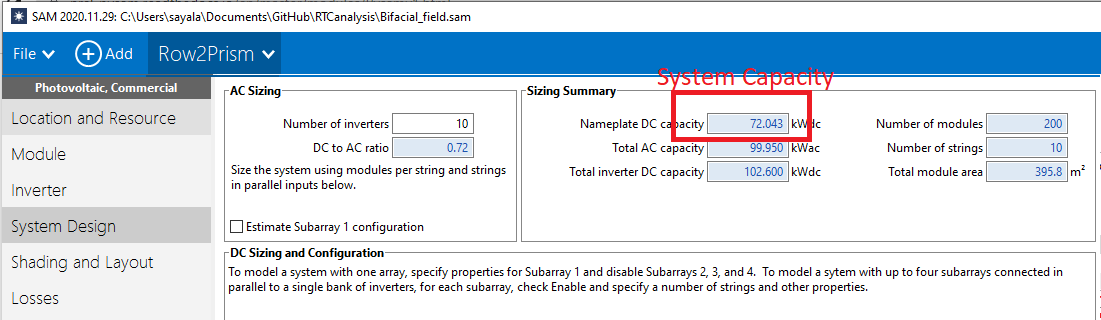

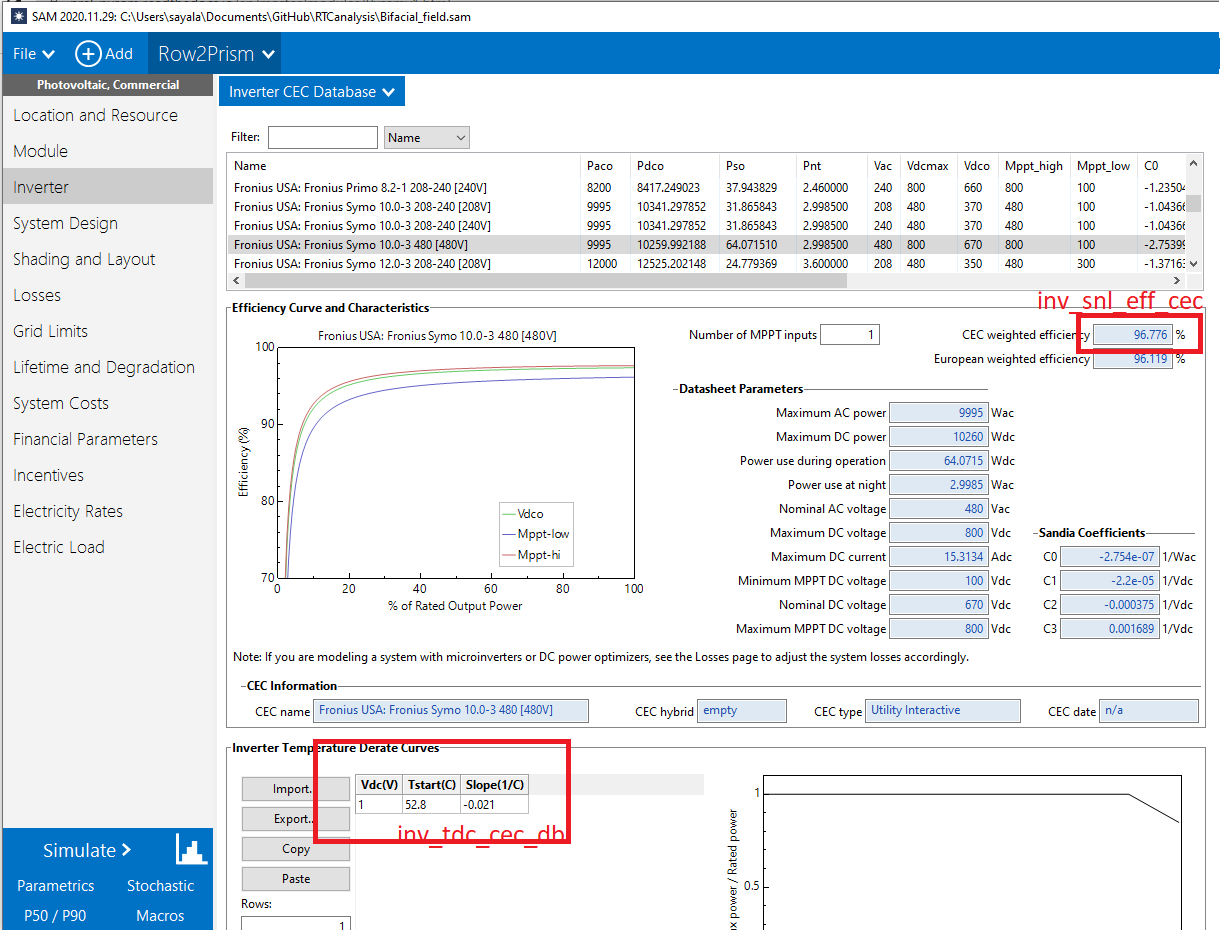

In [28]:
inv_snl_eff_cec = 96.776
system_capacity =  72.04280090332031
inverter_count = 10
inv_tdc_cec_db = [[1, 52.79999923706055, -0.020999999716877937]] # Temperature derate curves for CEC Database [(Vdc, C, %/C)]

sam1.SystemDesign.__setattr__('system_capacity', system_capacity)
sam1.Inverter.__setattr__('inv_snl_eff_cec', inv_snl_eff_cec)
sam1.Inverter.__setattr__('inverter_count', inverter_count)
sam1.InverterCECDatabase.__setattr__('inv_tdc_cec_db', inv_tdc_cec_db)

sam1.SolarResource.use_wf_albedo = 0


<a id='step7'></a>

## 7. Execute, Save and Explore Outputs

In [29]:
sam1.execute()

In [30]:
results = sam1.Outputs.export()

The cell below that is commented out saves the results to excel. Be mindful that the Outputs module keeps yearly, monthly, annual, and hourly values all together, so some variables store 1, 12, 8760 or more values.


To see which outputs might be of itnerest to you, look at the documentation:
[Outputs Pvsamv1] https://nrel-pysam.readthedocs.io/en/master/modules/Pvsamv1.html#outputs-group

In [31]:
'''
filesave = os.path.join('pySAM_NREL_HSAT_Outputs.xlsx')

workbook = xlsxwriter.Workbook(filesave)
worksheet = workbook.add_worksheet()

row=0
col=0

for key in results.keys():
    row += 1
    worksheet.write(row, col, key)
    worksheet.write(row, col + 1, str(results[key]))

workbook.close()
''';

For bifacial PV, we are more interested in front and rear irradiance, as well as the overall nominal performance. 

We might also want to see the albedo, dni, and dhi.

Let's get those values together into a dataframe, plot and save

In [32]:
rear = list(results['subarray1_poa_rear'])
front = list(results['subarray1_poa_front'])
power = list(results['subarray1_dc_gross'])
dni = list(results['dn'])
dhi = list(results['df'])
alb = list(results['alb'])

In [33]:
df = pd.DataFrame(list(zip(rear, front, power, dni, dhi, alb)),
               columns =['Grear', 'Gfront', 'DCP (kW)', 'DNI','DHI','alb'])
df['DCP (kW)']= df['DCP (kW)']/system_capacity # normalizing by the system_capacity
df = df[0:8760]

pySAM does not return the original timestamps. We can get them from the weatherfile. For this case, we are first triming to 8760 the data and then merging it with the read weatherfile timestamps.

In [34]:
weatherfile = pd.read_csv(solar_resource_file, skiprows=2)
timestamps = pd.to_datetime(weatherfile[['Year','Month','Day','Hour']])
df.index = timestamps
#df=df.rename_axis("index")
df.head(24)

,Grear,Gfront,DCP (kW),DNI,DHI,alb
2020-01-01 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.2
2020-01-01 01:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.2
2020-01-01 02:00:00,0.000000,0.000000,0.000000,0.000000,0.006899,0.2
2020-01-01 03:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.2
2020-01-01 04:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.2
2020-01-01 05:00:00,0.000000,0.000000,0.000000,0.000000,0.007147,0.2
2020-01-01 06:00:00,0.000000,0.000000,0.000000,0.224083,0.000000,0.2
2020-01-01 07:00:00,0.952828,10.864534,0.011111,29.900648,9.146110,0.2
2020-01-01 08:00:00,5.280836,62.891234,0.072767,39.650845,45.072811,0.2
2020-01-01 09:00:00,25.020240,424.175198,0.487038,488.902252,92.055008,0.2


In [35]:
import plotly.express as px
import matplotlib.pyplot as plt

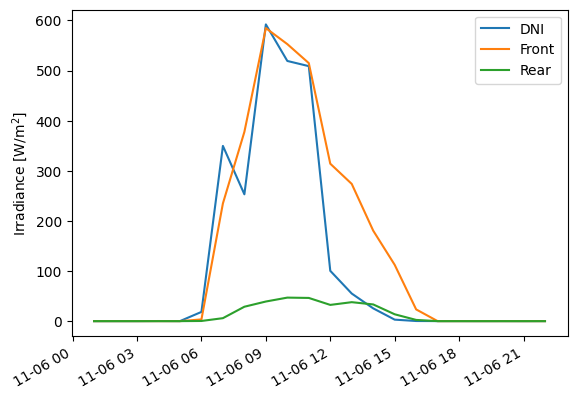

In [36]:
startdate = '2020-11-06 0:0:0'
enddate = '2020-11-06 23:0:0'

mybirthday = df[(df.index>startdate) & (df.index<enddate)]

fig, ax = plt.subplots()
plt.plot(mybirthday.DNI, label='DNI')
plt.plot(mybirthday.Gfront, label='Front')
plt.plot(mybirthday.Grear, label='Rear')
plt.ylabel("Irradiance [W/m$^2$]")
plt.legend()
fig.autofmt_xdate()

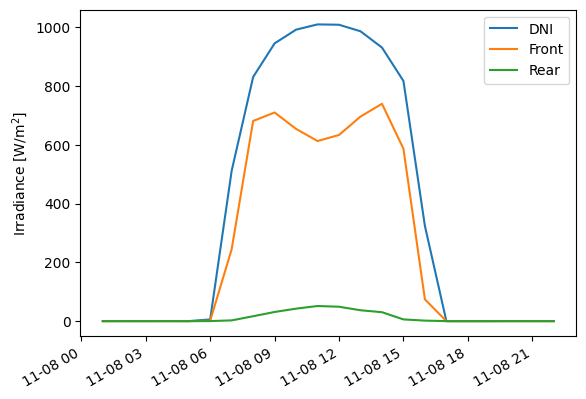

In [37]:
startdate = '2020-11-08 0:0:0'
enddate = '2020-11-08 23:0:0'

mybirthday = df[(df.index>startdate) & (df.index<enddate)]

fig, ax = plt.subplots()
plt.plot(mybirthday.DNI, label='DNI')
plt.plot(mybirthday.Gfront, label='Front')
plt.plot(mybirthday.Grear, label='Rear')
plt.ylabel("Irradiance [W/m$^2$]")
plt.legend()
fig.autofmt_xdate()

We can also explore with plotly any of the columns

In [38]:
px.line(df['DCP (kW)'])

<a id='step8'></a>

# ::Extra:: Comparison of pySAM vs SAM GUI values

If you have a JSON that you exported from SAM, it will look a bit different than the default pySAM object you created. pySAM groups all variables grouped by different categories. The below code will save that so you can compare the values between those of a SAM simulation and this default. Your SAM JSON will also have more variables for the grid, and economic calculation tabs which we have not created in the pySAM object yet.

This JSON file was saved from SAM Version 2020.11.29

In [39]:
# Prism File
Prismfile = os.path.join(Workingfolder,'Row2Prism.json')

with open(Prismfile) as f:
    dic = json.load(f)

As always, you can export just this values to xlsx with the code below. You will notice that the JSON doesn't save the same categories that are in the pysam PVsam1 object that we've been using before; it's just a long dictionary of all variables.

In [40]:
filesave = os.path.join(Workingfolder,'GUI JSON Row2Prism.xlsx')

workbook = xlsxwriter.Workbook(filesave)
worksheet = workbook.add_worksheet()

row=0
col=0

for key in dic.keys():
    row += 1
    worksheet.write(row, col, key)
    worksheet.write(row, col + 1, str(dic[key]))

workbook.close()

In [41]:
guiSAMdic = pd.DataFrame.from_dict(dic,orient='index')

To compare the JSON with the sam1 values we have created in this journal, we have to remove the categories from the sam object to just leave a long list of the dict values. The next cells do that.

In [42]:
maincomparisonvars = [sam1.AdjustmentFactors,
 sam1.CECPerformanceModelWithModuleDatabase,
 sam1.Inverter,
 sam1.InverterCECDatabase,
 sam1.Layout,
 sam1.Lifetime,
 sam1.Load,
 sam1.Losses,
 sam1.MermoudLejeuneSingleDiodeModel,
 sam1.Module,
 sam1.Shading,
 sam1.SolarResource,
 sam1.SystemDesign]

In [43]:
d4 = dict(maincomparisonvars[0].export())
for category in maincomparisonvars[1:]:
    d4.update(category.export())
    
pySAMdic = pd.DataFrame.from_dict(d4, orient='index')

Now let's join both dictionaries, so that only the values present in both are saved.  

In [44]:
result = pd.concat([guiSAMdic, pySAMdic], axis=1, join="inner")
result.columns = ['guiSAM', 'pySAM']
result.to_csv(os.path.join(Workingfolder, 'Gui vs PySam Values Comparison.csv'))